## Amazon Timestream With SageMaker
This is a sample notebook that lets Sagemaker integrate machine learning models
with Amazon Timestream.

In this notebook, we will use some sample Timestream queries to visualize data, 
visualize Anamoly scores, 
train a Random Cut Forest (RCF) model using the CPU utilization history etc.

In [111]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import timestreamquery as timestream
from IPython import display
import pandas as pd
import boto3
import botocore
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.models import NBEATSModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
# import sagemaker
import sys
import seaborn as sns
import numpy as np


## Logical view of data ##
```sql
DESCRIBE <db_name>.<table_name>
```

In [41]:
query_describe = """
DESCRIBE {}.{}
""".format(DB_NAME, TABLE_NAME)

describe_table = timestream.executeQueryAndReturnAsDataframe(client, query_describe, True)

display.display(describe_table)

QueryId: AEDQCANHOIMW7FSFQTSDCWV2B53PXC4O4EJ4CMEP46HD6L6O3PEYWPMTXLZO2NY
2022-10-06 11:37:35. QueryId: AEDQCANHOIMW7FSFQTSDCWV2B53PXC4O4EJ4CMEP46HD6L6O3PEYWPMTXLZO2NY Time: 0.181. First result: 0.181. Time to read results: 0.0.


,Column,Type,Timestream attribute type
0,tagId,varchar,DIMENSION
1,gateway_id,varchar,DIMENSION
2,measure_name,varchar,MEASURE_NAME
3,time,timestamp,TIMESTAMP
4,temperature,double,MULTI
5,humidity,double,MULTI
6,mc_2_5,bigint,MULTI
7,mc_10_0,bigint,MULTI
8,mc_4_0,bigint,MULTI
9,nc_10_0,bigint,MULTI


In [49]:
sensors = describe_table[describe_table["Timestream attribute type"] == "MULTI"]["Column"]
columns_to_extract = ", ".join([f"ROUND(AVG({sensor_name}), 2) as {sensor_name}_" for sensor_name in sensors])


In [52]:
query_get_all_data_last_30_days = f"""
SELECT BIN(time, 15m) as time_, {columns_to_extract}
FROM {DB_NAME}.{TABLE_NAME}
WHERE time > ago(30d)
GROUP BY BIN(time, 15m)
ORDER BY BIN(time, 15m)
"""

df = timestream.executeQueryAndReturnAsDataframe(client, query_get_all_data_last_30_days, True)
display.display(df)

QueryId: AEDQCANHOIZGLOHXEE4ALQQOYMB52NKNSTFFGQR7CCZPEMJKKWZXUWSSJ24USTA
2022-10-06 12:02:15. QueryId: AEDQCANHOIZGLOHXEE4ALQQOYMB52NKNSTFFGQR7CCZPEMJKKWZXUWSSJ24USTA Time: 3.207. First result: 3.207. Time to read results: 0.0.


,time_,temperature_,humidity_,mc_2_5_,mc_10_0_,mc_4_0_,nc_10_0_,mc_1_0_,nc_0_5_,nc_2_5_,nc_1_0_,nc_4_0_,typical_particle_size_
0,2022-09-16 14:15:00.000000000,11.80,99.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-16 14:30:00.000000000,11.90,99.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-16 14:45:00.000000000,11.93,99.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-16 15:00:00.000000000,11.85,99.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-16 15:15:00.000000000,11.73,99.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,2022-10-06 10:45:00.000000000,10.70,95.33,2.00,3.33,2.67,7.67,1.33,4.33,7.67,7.00,7.67,911.00
1904,2022-10-06 11:00:00.000000000,10.80,97.67,2.33,3.33,3.33,10.67,1.33,6.33,10.33,9.00,10.67,1121.33
1905,2022-10-06 11:15:00.000000000,10.90,98.67,3.33,5.67,4.67,9.00,1.33,3.33,9.00,7.33,9.00,1008.33
1906,2022-10-06 11:30:00.000000000,10.83,99.00,2.67,4.67,4.00,7.67,1.00,2.67,7.33,6.00,7.67,1163.33


# Set up N-BEATS model and train the model

In [ ]:
df.index = pd.to_datetime(df.time_)
df.index = df.index.tz_localize(None)
series = fill_missing_values(
    TimeSeries.from_dataframe(df, value_cols=[sensor_name + "_" for sensor_name in sensors], fill_missing_dates=True))

2022-10-06 14:34:44 darts.timeseries WARNING: Number of components is larger than 10 (12). Plotting only the first 10 components.


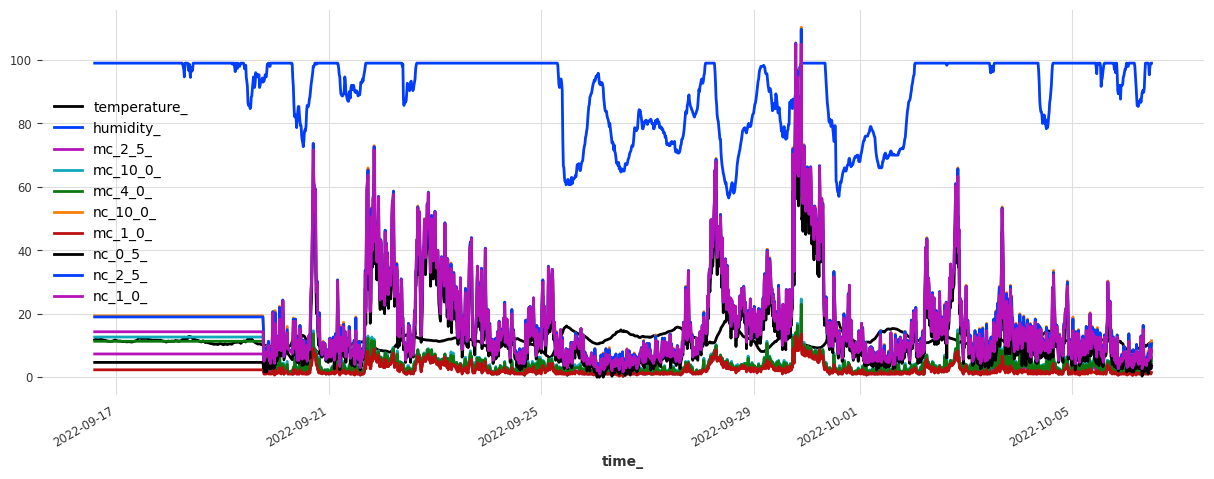

In [95]:
series.plot()

2022-10-06 14:45:51 darts.timeseries WARNING: Number of components is larger than 10 (12). Plotting only the first 10 components.


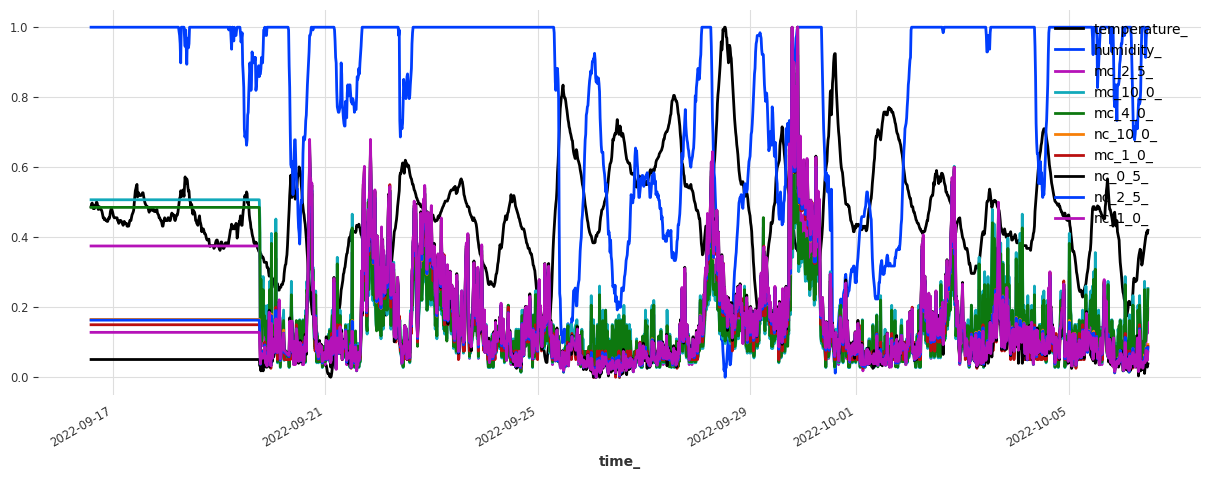

In [105]:
scalar = Scaler()
series = scalar.fit_transform(series).astype(np.float32)
series.plot()


In [132]:
import os
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = "\_NBEATS_model_03.pth.tar"   # file name to save the model under

EPOCHS = 50
INLEN = 480          # input size
BLOCKS = 64         
LWIDTH = 32
BATCH = 32          # batch size
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 96           # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = 3          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath = os.path.abspath(os.getcwd()) + SAVE

In [138]:
train, val = series[:-800], series[-800:]
model = model_nbeats = NBEATSModel(    input_chunk_length=INLEN,
                        output_chunk_length=N_FC, 
                        num_stacks=BLOCKS,
                        layer_widths=LWIDTH,
                        batch_size=BATCH,
                        n_epochs=EPOCHS,
                        nr_epochs_val_period=VALWAIT, 
                        likelihood=QuantileRegression(QUANTILES), 
                        optimizer_kwargs={"lr": LEARN}, 
                        model_name="NBEATS_EnergyES",
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=RAND,
                        force_reset=True,
                        save_checkpoints=True
                    )

In [139]:
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model_nbeats = NBEATSModel.load_model(mpath)                            # load previously model from disk 
else:
    model_nbeats.fit(  series=train, 
                val_series=val,
                verbose=True)
    print("have saved the model after training:", mpath)
    model_nbeats.save(mpath)

c:\Users\haako\Anaconda3\envs\tdt4290\lib\site-packages\darts\timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-10-06 14:59:59 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-10-06 14:59:59 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-10-06 14:59:59 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
2022-10-06 14:59:59 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 20.3 M
--------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

c:\Users\haako\Anaconda3\envs\tdt4290\lib\site-packages\pytorch_lightning\trainer\data_loading.py:428: UserWarning: The number of training samples (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
prediction_nbeats = model_nbeats.predict(n=96, num_samples=1000)

2022-10-06 14:50:17 darts.timeseries WARNING: Number of components is larger than 10 (12). Plotting only the first 10 components.
2022-10-06 14:50:26 darts.timeseries WARNING: Number of components is larger than 10 (12). Plotting only the first 10 components.


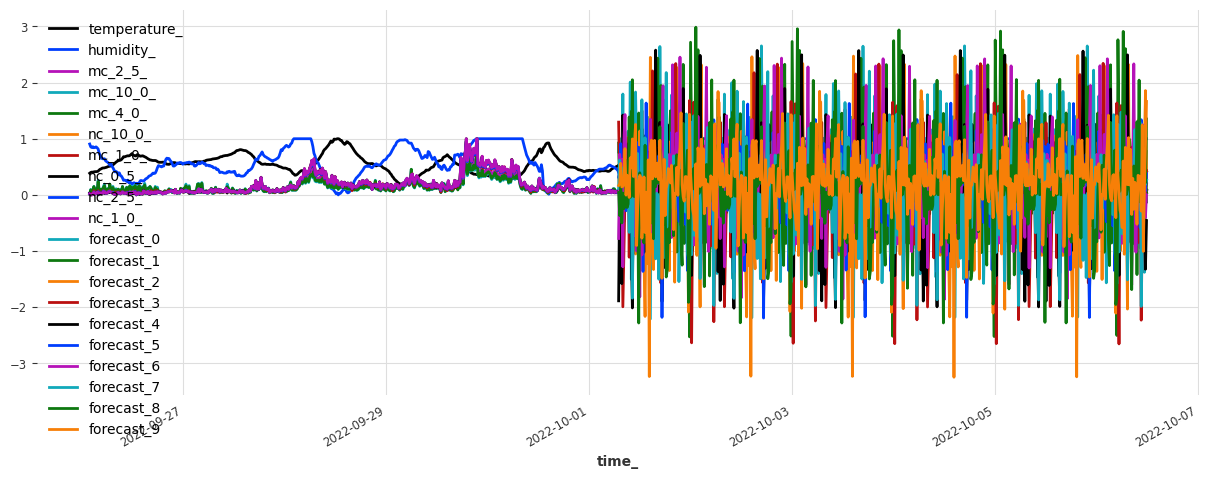

In [108]:
series[-1000:].plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)